In [2]:
%load_ext autoreload
# %reload_ext autoreload

In [1]:
import sys, os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils import (
    time_power_data,
    all_data,
    test_data,
    train_data,
    mean_absolute_percentage_error,
)
from preprocess import agg_data

import warnings

warnings.filterwarnings("ignore")

In [4]:
df = all_data()

In [5]:
day_agg = agg_data(df, time_frame="day")

In [6]:
day_agg.tail()

,active_power
time,
361,0.000000
362,140.813407
363,218.161640
364,0.029069
365,553.888305


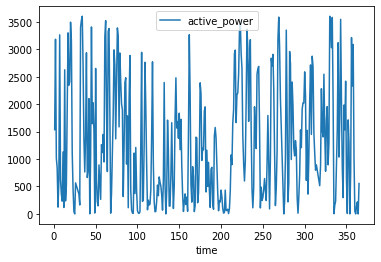

In [7]:
day_agg.plot()
plt.show()

There does not seem to be a clear trend for active_power.

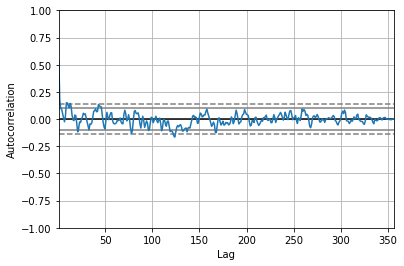

In [8]:
autocorrelation_plot(day_agg)
plt.show()

There seems to be minimal correlations with the lags.

## ARIMA

Using auto arima module to find best parameters for arima model.

In [9]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(
        timeseriesarray, start_p=1, start_q=1, test="adf", trace=True
    )
    return autoarima_model

In [10]:
arima_model = arimamodel(day_agg["active_power"])
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5849.790, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5972.145, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5855.659, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5854.926, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6296.741, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5852.450, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5848.601, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5850.085, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5850.546, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5850.352, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5851.073, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5851.704, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5857.802, Time=0.55 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.494 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  356
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2919.300
Date:                Thu, 10 Feb 2022   AIC                           5848.601
Time:                        22:51:33   BIC                           5867.975
Sample:                             0   HQIC                          5856.308
                                - 356                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    614.8759    304.962      2.016      0.044      17.161    1212.590
ar.L1          0.5249      0.231      2.277      0.023       0.073       0.977
ma.L1          0.0986      0.236      0.418      0.676      -0.364       0.562
ma.L2         -0.1409      0.147     -0.956      0.339      -0.430       0.148
sigma2      7.506e+05   6.88e+04     10.913      0.000    6.16e+05    8.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.24
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.50
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training

                               SARIMAX Results                                
Dep. Variable:           active_power   No. Observations:                  325
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2660.293
Date:                Thu, 10 Feb 2022   AIC                           5330.586
Time:                        22:51:34   BIC                           5349.505
Sample:                             0   HQIC                          5338.136
                                - 325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1307.5334    125.129     10.449      0.000    1062.285    1552.782
ar.L1          0.7424      0.152      4.896      0.000       0.445       1.040
ma.L1         -0.1197      0.168     -0.711      0.4

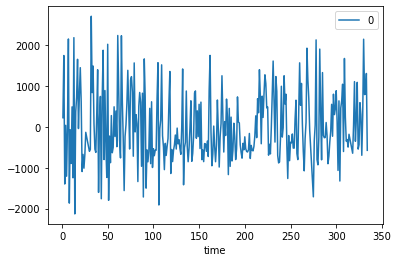

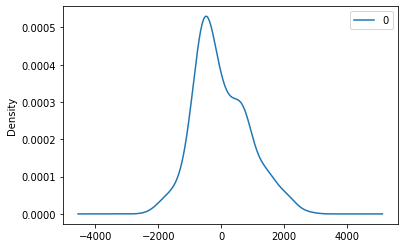

                 0
count   325.000000
mean      2.178982
std     869.057767
min   -2131.284822
25%    -586.524491
50%    -209.779697
75%     613.518600
max    2714.143578


In [11]:
train_df = train_data()
train_df_day = agg_data(train_df, time_frame="day")

# fit model
arima_model = ARIMA(train_df_day.active_power, order=(1, 0, 2))
arima_model = arima_model.fit()

# summary of fit model
print(arima_model.summary())

# line plot of residuals
residuals = pd.DataFrame(arima_model.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind="kde")
plt.show()

# summary stats of residuals
print(residuals.describe())

From the line plot of the residual errors, it suggests that there is no trend information captured by the model. There seems to be a constant mean.

From the density plot of the residual error values, it suggests that the errors are not Gaussian.

## Evaluation

In [12]:
test_df = test_data()
test_df_day = agg_data(test_df, time_frame="day")

<AxesSubplot:xlabel='time'>

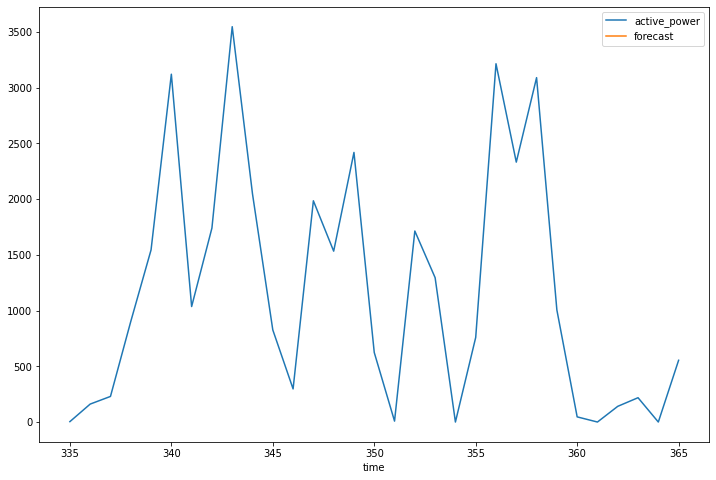

In [13]:
test_df_day["forecast"] = arima_model.predict(dynamic=True)
test_df_day[["active_power", "forecast"]].plot(figsize=(12, 8))

In [14]:
mean_absolute_percentage_error(test_df_day.active_power, test_df_day.forecast)

nan

## Future prediction

<AxesSubplot:>

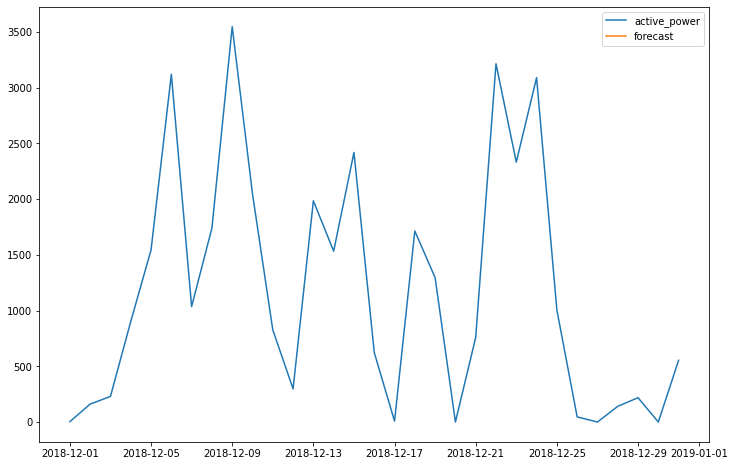

In [19]:
from pandas.tseries.offsets import DateOffset
import datetime

# Convert index from day number of year to date of year
test_df_day.reset_index(inplace=True)
test_df_day = test_df_day.rename(columns={"date_time": "day"})
test_df_day["day"] = test_df_day["day"].apply(
    lambda x: datetime.date(2018, 1, 1) + datetime.timedelta(days=x - 1)
)
test_df_day = test_df_day.set_index("day")

future_dates = [test_df_day.index[-1] + DateOffset(days=x) for x in range(1, 31)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=test_df_day.columns)
future_datest_df.tail()

future_df = pd.concat([test_df_day, future_datest_df])

future_df["forecast"] = arima_model.predict(start=32, end=63, dynamic=True)
future_df[["active_power", "forecast"]].plot(figsize=(12, 8))